<a href="https://colab.research.google.com/github/nikhilcoding0013/Harvard-AI-Summer-Program-2025/blob/main/Day_5_Hackathon_Cancer_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Benign vs. Malignant Breast Tumors Using Deep Learning

**Dataset**: [Multi Cancer Dataset](https://www.kaggle.com/datasets/obulisainaren/multi-cancer)



This dataset contains images of various cancer types, compiled for research and analysis purposes. It includes 8 main cancer classes and 26 subclasses, providing a rich resource for medical image classification and machine learning applications.

*Obuli Sai Naren. (2022). Multi Cancer Dataset. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/3415848*


| Cancer    | Classes | Images |
| -------- | ------- | ------- |
| Acute Lymphoblastic Leukemia	  | 4    | 20,000 |
| Brain Cancer	 | 3     | 15,000 |
| Breast Cancer	    | 2    | 10,000 |
| Cervical Cancer	    | 5    | 25,000 |
| Kidney Cancer	    | 2    | 10,000 |
| Lung and Colon Cancer	    | 5    | 25,000 |
| Lymphoma	    | 3    | 15,000 |
| Oral Cancer	    | 2    | 10,000 |




### Project Instructions
*   This project focuses on approaching building a classifier for cancer detection, a key problem in AI.
* We implement and compare two models on the Multi Cancer Dataset: a simple CNN and a ResNet model.
* There are many ways you can extend this workbook to answer your own research questions. Analyze the choice of hyperparameters, construct your own deep learing architecture, propose your own models and compare convergence rates... the world is your oyster!

## Environment Setup

In [1]:
!pip install kagglehub transformers timm -q

import os
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

## Dataset Exploration

Here, we directly download the Multi Cancer Dataset from Kaggle's library. The dataset is stored in `path`.

If Google Colab is not working well for you, you can alternatively directly download the dataset to your local drive and define the path manually.

In [2]:
import kagglehub
path = kagglehub.dataset_download("obulisainaren/multi-cancer")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/multi-cancer


Make sure you know how to navigate this dataset. Read the documentation as necessary from the README file: [Multi Cancer Dataset](https://www.kaggle.com/datasets/obulisainaren/multi-cancer)

In [3]:
# Explore file directory structure
!ls "$path"
%cd "$path/Multi Cancer/Multi Cancer/Breast Cancer"
!ls

'Multi Cancer'	 README.md
/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Breast Cancer
breast_benign  breast_malignant


Since the Multi Cancer Dataset is quite large and contains many different types of cancers, we'll further simplify our directory structure by copying only the subset of breast cancer data we want, then splitting into `training` and `valuation` folders.

We use `/content/multi-cancer-subset` as our local directory for storing our breast cancer subset. `/content` is simply Google Colab's home directory (which you can find on the sidebar, under the Folder icon). You may change this as you need.

In [4]:
%rm -rf "/content/multi-cancer-subset"

In [5]:
# Assume we want to focus on "Breast Cancer"
# We'll create a subset for demonstration purposes
# Make an easily accessible directory to store our subset
subset_dir = "/content/multi-cancer-subset"
os.makedirs(os.path.join(subset_dir),exist_ok=True)

train_dir = os.path.join(subset_dir, "train")
val_dir = os.path.join(subset_dir, "val")

# Create the necessary directories
os.makedirs(os.path.join(train_dir, "breast_benign"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "breast_malignant"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "breast_benign"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "breast_malignant"), exist_ok=True)

In [6]:
# Prepare to a small number of images from the original dataset to local directory paths
breast_benign_path = os.path.join(path, "Multi Cancer/Multi Cancer/Breast Cancer", "breast_benign")
breast_malignant_path = os.path.join(path, "Multi Cancer/Multi Cancer/Breast Cancer", "breast_malignant")

In [7]:
# Get image files
benign_images = sorted([f for f in os.listdir(breast_benign_path) if f.endswith(".jpg")])
malignant_images = sorted([f for f in os.listdir(breast_malignant_path) if f.endswith(".jpg")])

# Copy images (using only a small subset)
# Let's take 20 images for train and 10 for val from each class.
# You can change the proportion of valuation data out of total data.


for img in benign_images[:20]:
    shutil.copy(os.path.join(breast_benign_path, img), os.path.join(train_dir, "breast_benign"))
for img in benign_images[-10:]:
    shutil.copy(os.path.join(breast_benign_path, img), os.path.join(val_dir, "breast_benign"))

for img in malignant_images[:20]:
    shutil.copy(os.path.join(breast_malignant_path, img), os.path.join(train_dir, "breast_malignant"))
for img in malignant_images[-10:]:
    shutil.copy(os.path.join(breast_malignant_path, img), os.path.join(val_dir, "breast_malignant"))


# # HINT: For making the portion sizing more ubiguitous
# val_data_proportion = 0.2
# num_benign_data = len(benign_images)
# num_malignant_data = len(malignant_images)

In [8]:
print("Created a small train/val subset in:", subset_dir)

Created a small train/val subset in: /content/multi-cancer-subset


## Data Preprocessing

Now that we've organized our data into training and validation sets, it's time to preprocess the images and apply augmentation techniques. Data augmentation helps in artificially increasing the diversity of our training data, which can lead to better model generalization.

First, we perform potential transformations on the images of the data. Here are some potential functions to use:
1. `Resize`: `transforms.Resize((512,512))` resizes to the image to `512px x 512px`
2. `RandomRotation`: `transforms.RandomRotation(10)` randomly rotates images within a range of +/- 10 degrees.
3. `RandomHorizontalFlip`
4. `RandomResizedCrop`
5. `CenterCrop`

Once you're done with transformations, you should then use `ToTensor` and `Normalize` to make sure the results still follow input data characertistics.


**HINTS:**
* The images are currently `512px × 512px`. This is big and will potentially be slow to train; should we resize to lower dimensions? Maybe... `224px x 224 px`?
*  `RandomRotation()`, `RandomHorizontalFlip()`, `RandomResizedCrop()` can all be applied with whatever parameters you feel is fitting.
* Notice that we didn't give example implementations for every function. To figure out how to use them, **write the function in code and hover your mouse over the function name.** Google Colab should automatically pop up documentation.
* `val_transforms` should also have a `ToTensor()` and `Normalize()` after applying the transformations. You can directly use the lines from `train_transforms` as reference for how to implement it in `val_transforms`.

In [9]:
train_transforms = transforms.Compose([
    # TODO
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    # ENDTODO
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transforms = transforms.Compose([
    # TODO
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # ENDTODO
])

In [123]:
# Create datasets from the subset directories
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Updated batch size after random search
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # Updated batch size after random search

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['breast_benign', 'breast_malignant']


## Defining the CNN

With our data preprocessed and loaded, we can now define a simple Convolutional Neural Network (CNN) using PyTorch. CNNs are particularly effective for image classification tasks due to their ability to capture spatial hierarchies in images.

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Here are some potential layers to use:
1. `nn.Conv2d`
2. `nn.MaxPool2d`
3. `nn.Linear`
4. `nn.Dropout`

Make sure your layers are connected (dimensions match).

**HINT**:
* We've implemented a similar CNN on Day 4. Feel free to use it as reference!
* For the `Conv2d` function, the first parameter is the `in_channel`. Here, we're working with RGB colored images--how many channels should we allow? (Think: RGB.)


In [67]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        # TODO: Add 2 Conv2d layers, then a MaxPool2d layer.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # ENDTODO

        self.fc1 = nn.Linear(64 * 56 * 56, 256)

        # TODO: Add another Linear layer, ending with the number of classes, then a Dropout layer.
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        # ENDTODO


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(class_names)).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## CNN Model Training

With our CNN defined, the next step is to train it using our prepared dataset. Training involves feeding data through the network, computing loss, and updating the model's weights to minimize that loss.

**Hint:**
* For `learning_rate`, choose a slower rate that we have used before during class.
* For `num_epochs`, keep it low so we can train faster while we're still developing. Just 1-2 epochs is fine.

In [68]:
# TODO
learning_rate = 0.0001  # Optimal learning rate after random search
num_epochs = 4
# ENDTODO

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Now, we want to train over the given number of epochs. We'll keep track of some statistics per epoch.

In [69]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += labels.size(0)

    # TODO: Average our accumulated loss and accuracy with the total number of samples processed.
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    # ENDTODO
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

Epoch 1/4 - Loss: 0.6949, Acc: 0.5750
Epoch 2/4 - Loss: 0.6644, Acc: 0.5750
Epoch 3/4 - Loss: 1.0405, Acc: 0.5000
Epoch 4/4 - Loss: 0.6475, Acc: 0.6750


## CNN Model Evaluation

After training, it's crucial to evaluate our model's performance on a separate validation set to understand how well it generalizes to unseen data.

In [70]:
model.eval()
val_running_corrects = 0
val_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_running_corrects += torch.sum(preds == labels).item()
        val_total += labels.size(0)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# TODO
val_acc = val_running_corrects / val_total
# ENDTODO
print(f"Validation Accuracy: {val_acc:.4f}")

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

Validation Accuracy: 0.5000


# Transfer Learning: Using a Pretrained Model (ResNet)

While our simple CNN provides a foundational understanding, leveraging more advanced architectures like ResNet can lead to improved performance. ResNet (Residual Network) is renowned for its deep architecture and ability to mitigate issues like vanishing gradients through skip connections.

In [124]:
from torchvision import models

# 1. Load a pretrained ResNet model
resnet_model = models.resnet18(pretrained=True)

num_neurons = 224 # Updated amount after random search, original was 256


In [125]:
# 2. Modify the final layer to match the number of classes in our dataset
# The original ResNet18 has a final layer with 1000 outputs. We have 2 classes.
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, num_neurons),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(num_neurons, len(class_names))
)

resnet_model = resnet_model.to(device)

In [126]:
# 3. Optionally, freeze some layers to speed up training and rely on learned features.
# For example, to freeze all but the final layer:
# for param in resnet_model.parameters():
#     param.requires_grad = False
# for param in resnet_model.fc.parameters():
#     param.requires_grad = True
#
# In this example, let's train all layers for better results, but with a small dataset,
# this might lead to overfitting. Adjust based on performance.

# Define optimizer and criterion for ResNet

# TODO. Hint: This is very similar to the CNN criterion and optimizer.
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
# ENDTODO

resnet_num_epochs = 4  # Optimal amt of Epochs after random search

In [127]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects+= torch.sum(preds == labels).item()
        total += labels.size(0)

    # TODO
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    # ENDTODO
    return epoch_loss, epoch_acc

In [128]:
for epoch in range(resnet_num_epochs):
    epoch_loss, epoch_acc = train_one_epoch(
        resnet_model,
        train_loader,
        resnet_optimizer,
        resnet_criterion,
        device
    )
    print(f"[ResNet] Epoch {epoch+1}/{resnet_num_epochs} - "
      f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

[ResNet] Epoch 1/4 - Loss: 0.8169, Acc: 0.3250
[ResNet] Epoch 2/4 - Loss: 0.6798, Acc: 0.6000
[ResNet] Epoch 3/4 - Loss: 0.5210, Acc: 0.6750
[ResNet] Epoch 4/4 - Loss: 0.5484, Acc: 0.7750


In [129]:
# 5. Evaluate the ResNet model on the validation set
def evaluate(model, dataloader, device):
    model.eval()
    val_running_corrects = 0
    val_total = 0
    resnet_all_preds = []
    resnet_all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels).item()
            val_total += labels.size(0)
            resnet_all_preds.append(preds.cpu().numpy())
            resnet_all_labels.append(labels.cpu().numpy())

    resnet_val_acc = val_running_corrects / val_total

    resnet_all_preds = np.concatenate(resnet_all_preds)
    resnet_all_labels = np.concatenate(resnet_all_labels)
    return resnet_val_acc, resnet_all_preds, resnet_all_labels

In [130]:
resnet_val_acc, resnet_all_preds, resnet_all_labels = evaluate(
    resnet_model,
    val_loader,
    device
)
print(f"[ResNet] Validation Accuracy: {resnet_val_acc:.4f}")

[ResNet] Validation Accuracy: 0.7500


In [23]:
from sklearn.model_selection import ParameterSampler

In [24]:
def make_resnet(num_neurons, num_classes, device):
    resnet_model = models.resnet18(pretrained=True)
    num_features = resnet_model.fc.in_features
    resnet_model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, num_neurons),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(num_neurons, len(class_names))
    )
    resnet_model = resnet_model.to(device)
    return resnet_model

In [64]:
param_dist = {
    "lr":          [1e-4, 1e-3, 1e-2],
    "num_epochs":  [2, 3, 4],
    "batch_size":  [8, 16, 32, 64],
    "num_neurons": [128, 224, 256, 512],
}

i=0
n_iter = 6
search_configs = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
best_val_acc = 0.0
best_cfg = None

for cfg in search_configs:
    i += 1
    lr = cfg["lr"]
    num_epochs = cfg["num_epochs"]
    bs = cfg["batch_size"]
    hn = cfg["num_neurons"]

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True,  num_workers=4)
    val_loader = DataLoader(val_dataset,   batch_size=bs, shuffle=False, num_workers=4)

    # Build
    resnet_model = make_resnet(hn, num_classes=len(class_names), device=device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # Train
    for epoch in range(num_epochs):
      epoch_loss, epoch_acc = train_one_epoch(
        resnet_model, train_loader, optimizer, criterion, device
      )
    # Eval
    val_acc, _, _ = evaluate(resnet_model, val_loader, device)

    # Get best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_cfg = cfg

    print(i)

print(f"→ Best val_acc={best_val_acc:.4f} with config:")
print(best_cfg)

1
2
3
4
5
6
→ Best val_acc=0.9000 with config:
{'num_neurons': 224, 'num_epochs': 4, 'lr': 0.0001, 'batch_size': 64}


## Comparing Convergence Results

To gain a deeper understanding of how both models perform over time, we'll track and visualize their training and validation loss and accuracy across epochs. This comparison will highlight the strengths and potential weaknesses of each architecture.

This is a very versatile function--we highly recommend using it to compare results across models!

In [114]:
import matplotlib.pyplot as plt

# Function to train and validate a model, returning history of losses and accuracies
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, num_epochs=2, device='cpu', model_name='Model'):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += labels.size(0)

        # TODO
        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        # ENDTODO

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels).item()
                val_total += labels.size(0)

        # TODO
        val_loss = val_running_loss / val_total
        val_acc = val_running_corrects / val_total
        # ENDTODO

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }


First, let us train and validate our simple CNN model, and store its history of results.

In [82]:
# Assuming 'model' is your SimpleCNN and you've already defined optimizer and criterion
cnn_history = train_and_validate(model, optimizer, criterion, train_loader, val_loader,
                                 num_epochs=4, device=device, model_name="CNN")


[CNN] Epoch 1/4 - Train Loss: 0.3461, Train Acc: 0.8750, Val Loss: 1.3379, Val Acc: 0.5000
[CNN] Epoch 2/4 - Train Loss: 0.3182, Train Acc: 0.9000, Val Loss: 1.3420, Val Acc: 0.5000
[CNN] Epoch 3/4 - Train Loss: 0.2860, Train Acc: 0.9250, Val Loss: 1.3037, Val Acc: 0.4500
[CNN] Epoch 4/4 - Train Loss: 0.2235, Train Acc: 0.9250, Val Loss: 1.2754, Val Acc: 0.4000


Now, let us train and validate the ResNet model,and store its history of results.

In [131]:
from torchvision import models

resnet_model = models.resnet18(pretrained=True)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, len(class_names))
resnet_model = resnet_model.to(device)

resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)
resnet_criterion = nn.CrossEntropyLoss()

resnet_history = train_and_validate(resnet_model, resnet_optimizer, resnet_criterion,
                                    train_loader, val_loader,
                                    num_epochs=4, device=device, model_name="ResNet")


[ResNet] Epoch 1/4 - Train Loss: 0.7104, Train Acc: 0.5750, Val Loss: 0.4360, Val Acc: 0.9500
[ResNet] Epoch 2/4 - Train Loss: 0.3267, Train Acc: 0.9750, Val Loss: 0.3800, Val Acc: 0.8500
[ResNet] Epoch 3/4 - Train Loss: 0.1559, Train Acc: 1.0000, Val Loss: 0.3514, Val Acc: 0.9000
[ResNet] Epoch 4/4 - Train Loss: 0.0788, Train Acc: 1.0000, Val Loss: 0.3307, Val Acc: 0.8500


Now let's plot our performance results and compare the two models!

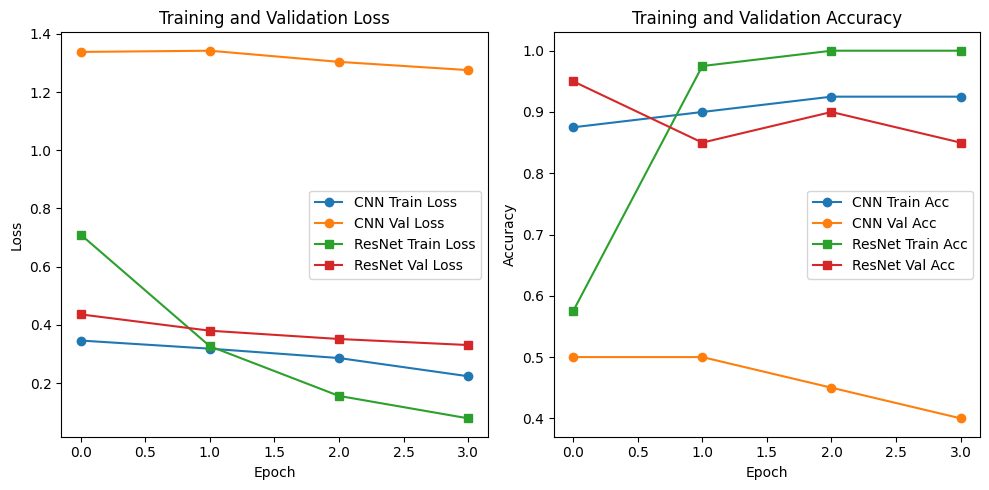

In [132]:
# Plot loss comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history['train_loss'], label='CNN Train Loss', marker='o')
plt.plot(cnn_history['val_loss'], label='CNN Val Loss', marker='o')
plt.plot(resnet_history['train_loss'], label='ResNet Train Loss', marker='s')
plt.plot(resnet_history['val_loss'], label='ResNet Val Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(cnn_history['train_acc'], label='CNN Train Acc', marker='o')
plt.plot(cnn_history['val_acc'], label='CNN Val Acc', marker='o')
plt.plot(resnet_history['train_acc'], label='ResNet Train Acc', marker='s')
plt.plot(resnet_history['val_acc'], label='ResNet Val Acc', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Implementing Your Extensions

In this tutorial, we have shown you an example of one possible extension: **Transfer Learning**. In other words, we used a pretrained model (e.g. ResNet18) and fine-tuned the last few layers for this specific classification task, comparing performance and training time.

**Potential Ideas for Further Extensions:**


1.   **Architecture Tuning**: Adding more convolutional layers, adjusting the number of filters, introducting dropout layers before fully connected layers to reduce overfitting.
2.   **Hyperparameter Adjustments**: Change the learning rate, use a different optimizer (SGD, RMSprop), or vary the batch size, train for more epochs and compare performance.
3. **Data Augmentation**: Incorporate different transformations (flips, rotations, crops) to improve generalization.
4. **Propose Different Models and Compare Results**: We have already defined a function that can easily allow you to compare the convergence results for different models (`train_and_validate`). Make more models, justify your choices, and compare your performance!

Reminder that our `train_and_validate` function can be very helpful to compare results across design decisions!

